# 1.1 Sparsity-promoting linear model for classification and identification of salient features

In this demo code, we will continue from 1.0 and:

<ul>
<li>Enforce sparsity for weight calibration</li>
<li>Identify optimal regularization penalty</li>
<li>Apply a mask for the important weights</li>
<li>Use the important weights to predict</li>
<li>Remap the important weights to salient features in the training image</li>
</ul>

In [2]:
#load digit MNIST dataset 

%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#normalize the images
x_train = np.expand_dims(x_train/255.0, axis=-1)
x_test = np.expand_dims(x_test/255.0, axis=-1)

#convert to one-hot vector encoding
from keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

#define the labels
class_names = ['zero', 'one', 'two', 'three', 'four',
               'five', 'six', 'seven', 'eight', 'nine']

#flatten the 2D images
x_train_f = np.reshape(x_train, [x_train.shape[0], -1])
x_test_f = np.reshape(x_test, [x_test.shape[0], -1])

print(x_train.shape)
print(x_train_f.shape)
print(y_train.shape)
print(x_test.shape)
print(x_test_f.shape)
print(y_test.shape)
print(y_train_one_hot.shape)
print(y_test_one_hot.shape)

(60000, 28, 28, 1)
(60000, 784)
(60000,)
(10000, 28, 28, 1)
(10000, 784)
(10000,)
(60000, 10)
(10000, 10)


In [3]:
#plot function for sample images

def plot_tile(samples):
    
    num_samples, x_dim, y_dim, _ = samples.shape
    axes = (np.round(np.sqrt(num_samples))).astype(int)
    fig = plt.figure(figsize=(axes, axes))
    gs = gridspec.GridSpec(axes, axes)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_aspect('equal')
        plt.imshow(sample, cmap=plt.get_cmap('viridis'), aspect='auto')

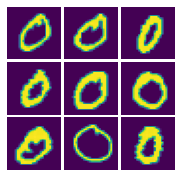

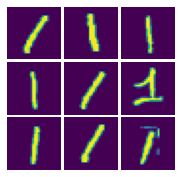

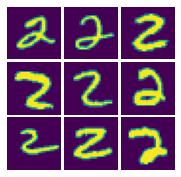

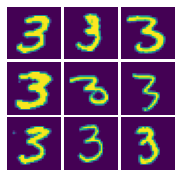

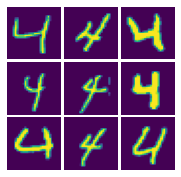

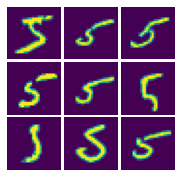

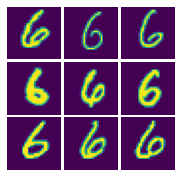

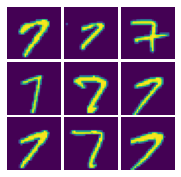

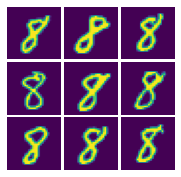

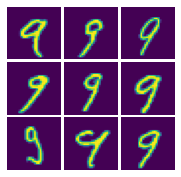

In [4]:
#visualize first 9 samples of input images based on class labels, within the training dataset

unique_labels, label_counts = np.unique(y_train, return_counts=True)

for label in unique_labels:
    x_train_perlabel = x_train[np.squeeze(y_train) == label]
    fig = plot_tile(x_train_perlabel[0:9, :, :])

In [5]:
#define a model with Keras 

import keras
from keras.models import Model
from keras.layers import Layer, Flatten
from keras.layers import Input, Reshape

from keras import backend as K
from keras.engine.base_layer import InputSpec

from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers, activations, initializers, constraints
from keras.constraints import Constraint
from IPython.display import clear_output
from keras.callbacks import History 


#function to view training and validation losses
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss", c = 'green')
        plt.plot(self.x, self.val_losses, label="val_loss", c = 'red')
        plt.legend()
        plt.show()

In [6]:
#create a custom Dense layer and inherit from the Layer class

class Dense(Layer):
    
    def __init__(self, units, mask, 
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
            
        super(Dense, self).__init__(**kwargs)
        self.units = units
        self.mask = mask
        self.output_dim = mask.shape[1]
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.mask = self.add_weight(name='mask', 
                              shape=(input_shape[1], self.output_dim),
                              initializer = self.mask_init,
                              trainable=False) 
        
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True
        
    def mask_init(self, dtype = None):
        
        mask = self.mask
        return tf.cast(mask, dtype = tf.float32)

    def call(self, inputs):
        
        kernel_wt = tf.math.multiply(self.kernel, self.mask)
        output = K.dot(inputs, kernel_wt)

        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer':
                regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(Dense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [7]:
#define the Ax=b system

input_x = Input(shape=(x_train_f.shape[1], )) 
output_y = Dense(units=y_train_one_hot.shape[1], 
                 mask=np.ones([x_train_f.shape[1], y_train_one_hot.shape[1]]), 
                 kernel_initializer='zeros', 
                 kernel_regularizer=regularizers.l1(1e-3), 
                 use_bias=False, activation='linear', name='MyDense')(input_x)

In [8]:
#set loss function, optimizer and compile

linear_model = Model(input_x, output_y)
opt = keras.optimizers.Adam(lr=1e-4)
linear_model.compile(optimizer=opt, 
                   loss="mse", 
                   metrics=['categorical_accuracy'])

#get summary of architecture parameters and plot arch. diagram
linear_model.summary()
from keras.utils import plot_model
plot_model(linear_model, to_file='linear_model.png')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
MyDense (Dense)              (None, 10)                15680     
Total params: 15,680
Trainable params: 7,840
Non-trainable params: 7,840
_________________________________________________________________


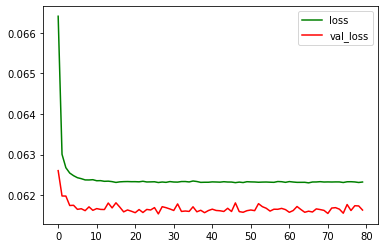

In [9]:
#train the neural network

plot_losses = PlotLosses()
linear_model.fit(x_train_f, y_train_one_hot,        
                epochs=80,
                batch_size=32,
                shuffle=True,
                validation_split=0.3,
                callbacks=[plot_losses])

In [10]:
#save and load the trained model

#linear_model.save('linear_model_sparse.h5')

#from keras.models import load_model
#linear_model = load_model('linear_model_sparse.h5')

In [11]:
#get the predictions for the training and testing dataset (just for this demo)

predictions_train = linear_model.predict(x_train_f)
predictions_test = linear_model.predict(x_test_f)

In [12]:
def getWeights(model, scaler=1):

    weights = model.layers[1].get_weights()

    plt.figure(figsize=(5,10))
    plt.imshow(weights[0], cmap='seismic', vmin=-1*scaler, vmax=1*scaler, aspect='auto')
    plt.xlim([-0.5, 9.5])
    for i in range(10):
        plt.axvline(x=i+0.5, c='k', linewidth=1)
    plt.colorbar()
    plt.tight_layout()
    plt.title('Weight matrix')
    
    plt.figure(figsize=(5,10))
    plt.imshow(weights[1], cmap='seismic', vmin=-1*scaler, vmax=1*scaler, aspect='auto')
    plt.colorbar()
    plt.tight_layout()
    plt.title('Mask')

    return weights

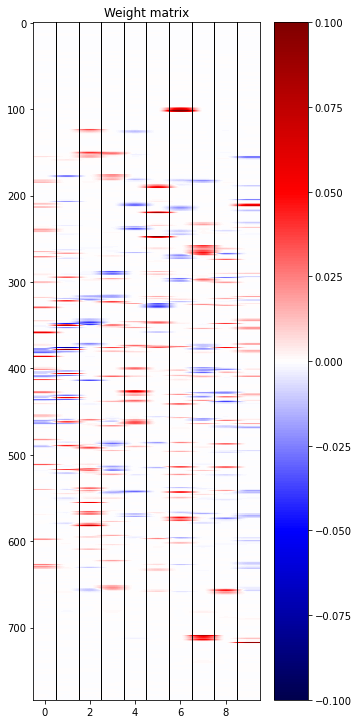

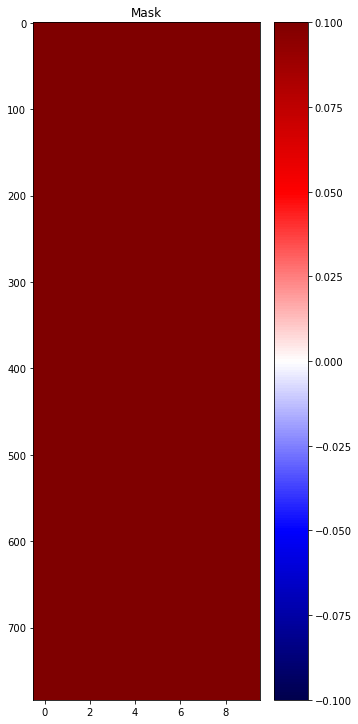

In [13]:
wt = getWeights(linear_model, scaler=0.1)

In [14]:
#get the accuracy of the trained model on the training and testing dataset

train_loss, train_acc = linear_model.evaluate(x_train_f,  y_train_one_hot, verbose=2)
print("Training accuracy: {:.4f}".format(train_acc))

test_loss, test_acc = linear_model.evaluate(x_test_f,  y_test_one_hot, verbose=2)
print("Testing accuracy: {:.4f}".format(test_acc))

Training accuracy: 0.8046
Testing accuracy: 0.8142


In [15]:
#function to pretty plot confusion matrix (modified from SKLEARN)

import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5477   10   33   30   15   32  220   43   60    3]
 [   0 6574   30   13    3    3   16   18   81    4]
 [  97  442 4509   92  135    0  306  231  117   29]
 [  56  245  224 5007   27   50  128  215  101   78]
 [  26  171   46   25 5017   44  122   61   63  267]
 [ 202  206   82  935  149 2911  281  163  305  187]
 [ 131  113   76   10   50   50 5441    4   43    0]
 [ 100  259   52   49   88    9    5 5528   15  160]
 [  99  870  120  382   82  203  121  117 3706  151]
 [ 121  164   33  144  473   22   22  837   27 4106]]

Classification Report (Training)
              precision    recall  f1-score   support

        zero       0.87      0.92      0.90      5923
         one       0.73      0.98      0.83      6742
         two       0.87      0.76      0.81      5958
       three       0.75      0.82      0.78      6131
        four       0.83      0.86      0.84      5842
        five       0.88      0.54      0.67      5421
         six    

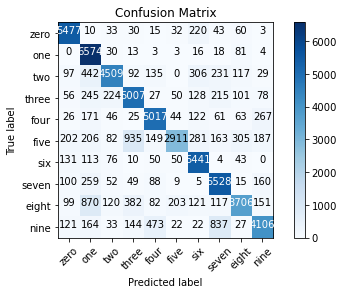

In [16]:
#print the confusion matrix and classification report

from sklearn.metrics import classification_report, confusion_matrix

matrix = confusion_matrix(y_train, predictions_train.argmax(axis=1))
cm1 = plot_confusion_matrix(cm=matrix, classes=class_names, title='Confusion Matrix')

print('\nClassification Report (Training)')
print(classification_report(y_train, predictions_train.argmax(axis=1), target_names=class_names))

In [17]:
#functions to plot training data and the likelihood (from KERAS)

def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)
    
def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    
    plt.xticks(range(10))

    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([-0.3, 1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

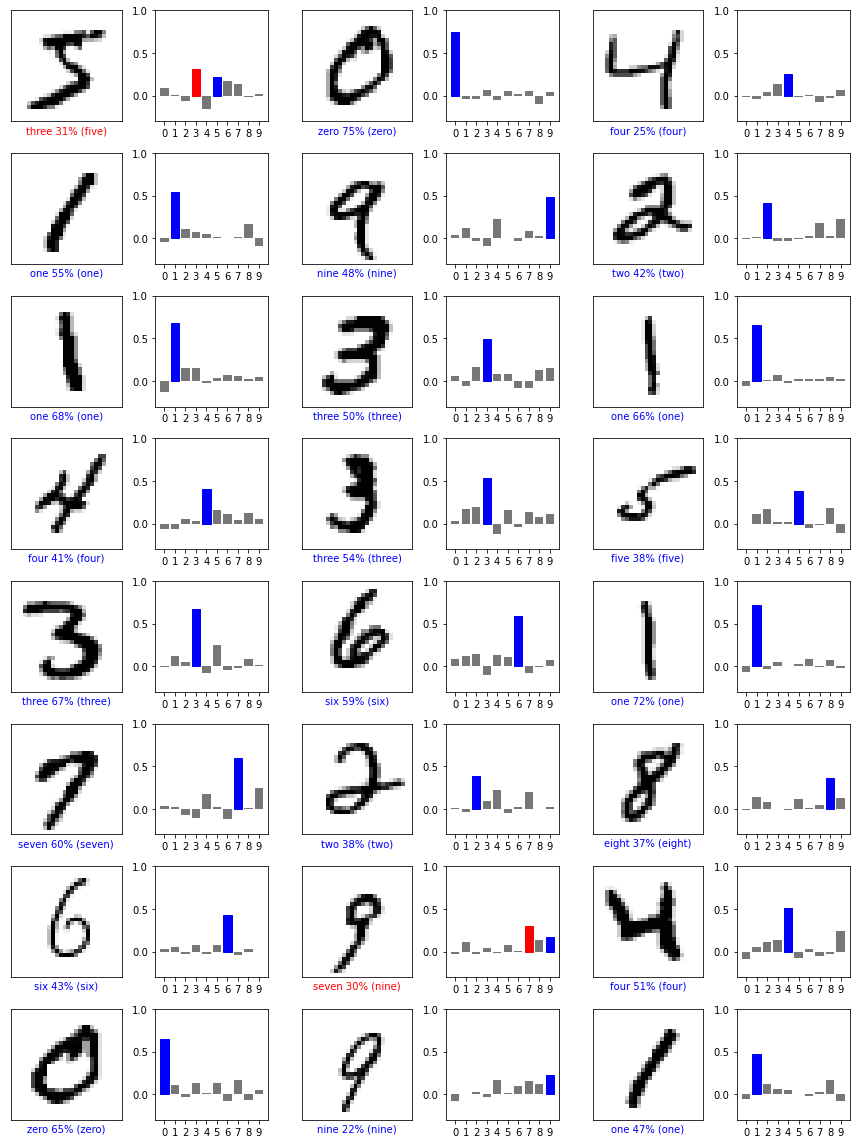

In [18]:
#plot some test images with predicted vs true labels
#correct predictions (colored blue) and incorrect predictions (colored red)

num_rows = 8
num_cols = 3
num_images = num_rows*num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions_train[i], y_train, x_train)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions_train[i], y_train)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Histogram of weights')

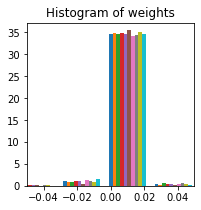

In [19]:
#histogram of weights

plt.figure(figsize=(3,3))
plt.hist(wt[0], density=True)
plt.xlim([-0.05, 0.05])
plt.title('Histogram of weights')

Text(0.5, 1.0, 'Mask')

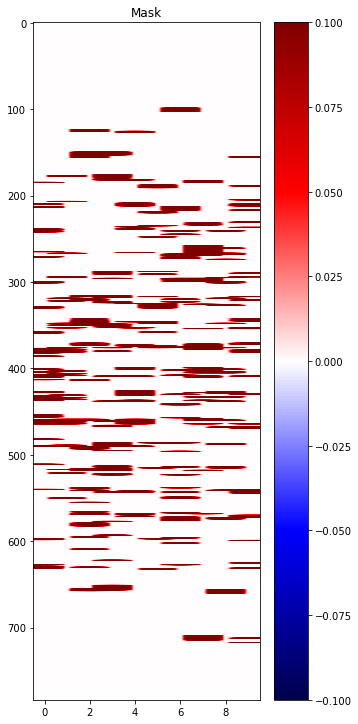

In [21]:
#create a mask based on a threshold defined on the weights

sparse_mask = np.zeros([x_train_f.shape[1], y_train_one_hot.shape[1]])

kernel_wt = wt[0]

for i in range(kernel_wt.shape[0]):
    for j in range(kernel_wt.shape[1]):
        if (np.abs(kernel_wt[i, j]) >= 0.01):
            sparse_mask[i, j] = 1
            
scaler = 0.1
plt.figure(figsize=(5,10))
plt.imshow(sparse_mask, cmap='seismic', vmin=-1*scaler, vmax=1*scaler, aspect='auto')
plt.colorbar()
plt.tight_layout()
plt.title('Mask')

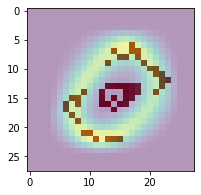

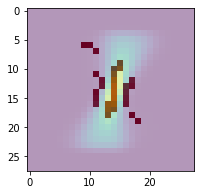

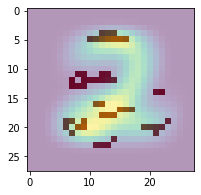

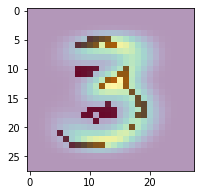

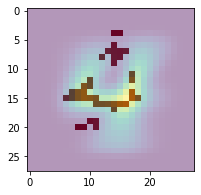

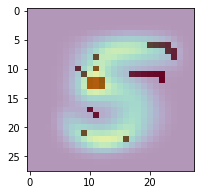

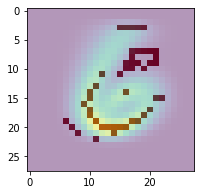

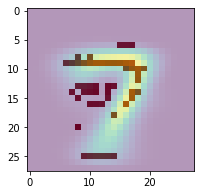

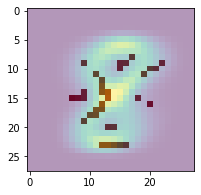

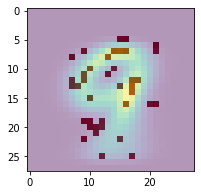

In [22]:
#reshape for each digit and overlay plot on the mean of each digit (from training dataset)
